In [1]:
%load_ext rpy2.ipython
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

In [2]:
%%R
# Your R code here
install.packages('ggplot2', repos='http://cran.us.r-project.org', quiet=TRUE)
library(ggplot2)

In addition: Warning message:
package ‘ggplot2’ was built under R version 4.5.2 


In [3]:
%%R
# Make sure to run this first in the current session
df <- read.csv('/Users/srinathvenkatesh/Desktop/Projects/Hands_On_Machine_Learning_and_Deep_Learning_with_Python-master/Data/social_media_ad_optimization_raw.csv')

# Then run this immediately after
head(df)


  user_id age

 gender location interests ad_id ad_category ad_platform  ad_type
1   U0001  58      M      USA      Food A0001  Sportswear    Facebook    Image
2   U0002  55      F      USA      Tech A0002 Electronics    Facebook    Image
3   U0003  52      F       UK    Gaming A0003     Luggage   Instagram    Image
4   U0004  31      F      USA      Tech A0004     Gadgets    Facebook    Video
5   U0005  52      M    India      Tech A0005     Luggage   Instagram Carousel
6   U0006  32      F      USA   Fashion A0006 Electronics   Instagram    Video
  impressions clicks conversion time_spent_on_ad day_of_week device_type
1           3      0          0             3.38      Friday      Mobile
2           9      9          1             6.77    Saturday      Tablet
3          13     12          1            13.26   Wednesday      Mobile
4          14      5          0            24.41    Saturday     Desktop
5          10      5          0            21.43      Monday      Tablet
6           8      5  

In [4]:
%%R
# Define the character vector of column names
cat_cols <- c('user_id', 'gender', 'location', 'interests',
              'ad_id', 'ad_category', 'ad_platform', 'ad_type',
              'day_of_week', 'device_type')

# Iterate through the columns and convert them to factors (R's equivalent of categories)
for (col in cat_cols) {
  df[[col]] <- as.factor(df[[col]])
}

# Display the data types (structure) of the data frame
str(df)

# Alternatively, display just the types of the columns in a table format:
# sapply(df, class)


'data.frame':	500 obs. of  16 variables:
 $ user_id         : Factor w/ 500 levels "U0001","U0002",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ age             : int  58 55 52 31 52 32 59 32 38 55 ...
 $ gender          : Factor w/ 3 levels "F","M","Other": 2 1 1 1 2 1 2 3 2 1 ...
 $ location        : Factor w/ 6 levels "Australia","Canada",..: 6 6 5 6 4 6 3 2 1 3 ...
 $ interests       : Factor w/ 6 levels "Fashion","Fitness",..: 3 5 4 5 5 1 3 5 4 4 ...
 $ ad_id           : Factor w/ 50 levels "A0001","A0002",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ ad_category     : Factor w/ 6 levels "Apparel","Electronics",..: 6 2 5 4 5 2 1 1 4 6 ...
 $ ad_platform     : Factor w/ 2 levels "Facebook","Instagram": 1 1 2 1 2 2 1 1 2 1 ...
 $ ad_type         : Factor w/ 3 levels "Carousel","Image",..: 2 2 2 3 1 3 2 3 2 2 ...
 $ impressions     : int  3 9 13 14 10 8 8 7 5 9 ...
 $ clicks          : int  0 9 12 5 5 5 6 4 1 7 ...
 $ conversion      : int  0 1 1 0 0 1 1 1 1 1 ...
 $ time_spent_on_ad: num  3.38 6.77 13.26 24.41

In [5]:
%%R
# Calculate CTR with a conditional check to prevent division by zero, using ifelse()
# R's 'NA' is equivalent to Python's 'np.nan'
df$CTR <- ifelse(
  df$impressions > 0,
  df$clicks / df$impressions,
  NA
)

# Display a summary/description of the 'CTR' column
summary(df$CTR)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.2625  0.5333  0.5399  0.8571  1.0000 


In [6]:
%%R

# Define grouping columns
group_cols <- c("ad_platform", "ad_type", "day_of_week", "device_type")

# Aggregate using base R's aggregate function
# We must explicitly convert user_id back to numeric/integer type for aggregation purposes
ctr_group <- aggregate(
    x = list(
        total_impressions = df$impressions,
        total_clicks = df$clicks,
        # Convert user_id to numeric just for the count/sum operation here:
        n_records = as.numeric(df$user_id) 
    ),
    by = df[group_cols],
    FUN = sum # Use sum for all three columns now
)

# Calculate weighted CTR per combination (vectorized operation)
ctr_group$CTR_group <- ctr_group$total_clicks / ctr_group$total_impressions

# handle any groups with 0 impressions just in case (using base R ifelse)
ctr_group$CTR_group <- ifelse(
  ctr_group$total_impressions == 0,
  NA, # R's NA is equivalent to np.nan
  ctr_group$CTR_group
)

# Display the first few rows of the new data frame
head(ctr_group)


  ad_platform  ad_type day_of_week device_type total_impressions total_clicks
1    Facebook Carousel      Friday     Desktop                45           16
2   Instagram Carousel      Friday     Desktop                 4            2
3    Facebook    Image      Friday     Desktop                28           16
4   Instagram    Image      Friday     Desktop                14           10
5    Facebook    Video      Friday     Desktop                82           36
6   Instagram    Video      Friday     Desktop                27           10
  n_records CTR_group
1      1727 0.3555556
2       477 0.5000000
3      1168 0.5714286
4       632 0.7142857
5      1873 0.4390244
6       901 0.3703704


In [7]:
%%R

# Sort the data frame by "CTR_group" in descending order
ctr_group_sorted <- ctr_group[order(-ctr_group$CTR_group), ]

# Display the top 10 rows (combinations) by highest CTR
head(ctr_group_sorted, 10)


    ad_platform  ad_type day_of_week device_type total_impressions total_clicks
109   Instagram Carousel    Thursday      Tablet                 4            4
27     Facebook    Image    Thursday     Desktop                10            9
78    Instagram    Video     Tuesday      Mobile                38           34
112    Facebook    Video    Thursday      Tablet                19           17
113   Instagram    Video    Thursday      Tablet                16           14
12    Instagram    Video      Monday     Desktop                21           18
32    Instagram Carousel     Tuesday     Desktop                25           21
120    Facebook Carousel   Wednesday      Tablet                30           25
105   Instagram    Image      Sunday      Tablet                29           24
100    Facebook    Video    Saturday      Tablet                27           22
    n_records CTR_group
109       171 1.0000000
27        303 0.9000000
78       1633 0.8947368
112       452 0.8947368


In [8]:
%%R

# Display the bottom 10 rows (combinations) by lowest CTR
# The 'tail()' function works identically to the Python pandas .tail() method for data frames
tail(ctr_group_sorted, 10)


    ad_platform  ad_type day_of_week device_type total_impressions total_clicks
110    Facebook    Image    Thursday      Tablet                60           20
61     Facebook Carousel      Sunday      Mobile                58           19
29     Facebook    Video    Thursday     Desktop                19            6
45     Facebook    Image      Friday      Mobile                16            5
36    Instagram    Video     Tuesday     Desktop                60           18
20    Instagram Carousel      Sunday     Desktop                64           19
7      Facebook Carousel      Monday     Desktop                13            3
73     Facebook Carousel     Tuesday      Mobile                 5            1
58    Instagram    Image    Saturday      Mobile                34            6
25     Facebook Carousel    Thursday     Desktop                 7            0
    n_records CTR_group
110      2038 0.3333333
61        841 0.3275862
29       1068 0.3157895
45        108 0.3125000


In [30]:
%%R

# Install required packages if not already installed
install.packages("rpart", repos="http://cran.us.r-project.org")
install.packages("rpart.plot", repos="http://cran.us.r-project.org")
install.packages("tree", repos="http://cran.us.r-project.org")




The downloaded binary packages are in
	/var/folders/pg/9rp6_9vx18zb0xtnx9d57jtr0000gn/T//RtmpsT8pTO/downloaded_packages

The downloaded binary packages are in
	/var/folders/pg/9rp6_9vx18zb0xtnx9d57jtr0000gn/T//RtmpsT8pTO/downloaded_packages

The downloaded binary packages are in
	/var/folders/pg/9rp6_9vx18zb0xtnx9d57jtr0000gn/T//RtmpsT8pTO/downloaded_packages


trying URL 'http://cran.us.r-project.org/bin/macosx/big-sur-arm64/contrib/4.5/rpart_4.1.24.tgz'
Content type 'application/x-gzip' length 738572 bytes (721 KB)
downloaded 721 KB

trying URL 'http://cran.us.r-project.org/bin/macosx/big-sur-arm64/contrib/4.5/rpart.plot_3.1.3.tgz'
Content type 'application/x-gzip' length 1026343 bytes (1002 KB)
downloaded 1002 KB

trying URL 'http://cran.us.r-project.org/bin/macosx/big-sur-arm64/contrib/4.5/tree_1.0-45.tgz'
Content type 'application/x-gzip' length 175470 bytes (171 KB)
downloaded 171 KB



In addition: Warning message:
cex and tweak both specified, applying both 


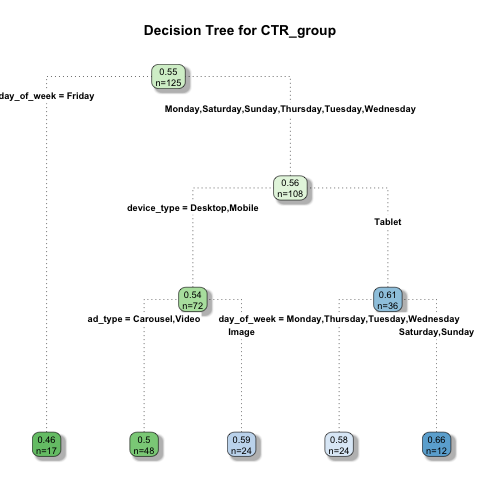

In [36]:
%%R

# Define grouping columns
group_cols <- c("ad_platform", "ad_type", "day_of_week", "device_type")

# Define the sample weights
sample_weight <- ctr_group$total_impressions

# Define the model formula
model_formula <- as.formula(paste("CTR_group ~", paste(group_cols, collapse = " + ")))

# Fit the Decision Tree Regressor
tree_model <- rpart(
    formula = model_formula,
    data = ctr_group,
    method = "anova", # anova specifies regression tree
    control = rpart.control(
        maxdepth = 3,       # shallow tree (max_depth=3)
        minsplit = 10,      # min_samples_leaf=5 roughly translates to minsplit=10 for internal nodes
        xval = 0            # disable cross-validation for speed
    ),
    weights = sample_weight
)

# Visualize the tree using rpart.plot with adjustments
rpart.plot(
    tree_model,
    type = 4,
    extra = 1, # extra=1 shows only the number of observations (less text)
    cex = 0.7, # cex controls character expansion (font size), 0.7 makes it smaller
    main = "Decision Tree for CTR_group",
    box.palette = "GnBu",
    branch.lty = 3,
    shadow.col = "gray",
    tweak = 1.1 # tweak expands the box size slightly
)


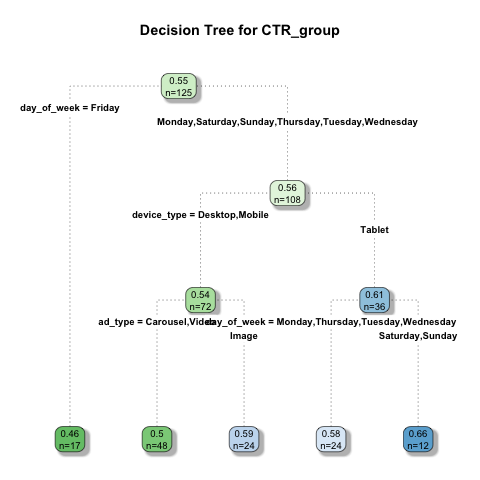

In [35]:
%%R

library(rpart)
library(rpart.plot)

# --- Add this line to adjust the output dimensions ---
# This command tells the graphics device (like the RStudio or VS Code plot viewer) 
# to use a specific width and height in inches when it renders the next plot.
options(repr.plot.width = 10, repr.plot.height = 6) 
# Note: 'repr.plot.width' and 'repr.plot.height' are specific options 
# used by environments like Jupyter/VS Code with the IRkernel package.
# They might not work in a pure R console.

# Define grouping columns
group_cols <- c("ad_platform", "ad_type", "day_of_week", "device_type")

# Define the sample weights
sample_weight <- ctr_group$total_impressions

# Define the model formula
model_formula <- as.formula(paste("CTR_group ~", paste(group_cols, collapse = " + ")))

# Fit the Decision Tree Regressor (rest of your model code remains the same)
tree_model <- rpart(
    formula = model_formula,
    data = ctr_group,
    method = "anova",
    control = rpart.control(
        maxdepth = 3,
        minsplit = 10,
        xval = 0
    ),
    weights = sample_weight
)

# Visualize the tree using rpart.plot
rpart.plot(
    tree_model,
    type = 4,
    extra = 1, 
    main = "Decision Tree for CTR_group",
    box.palette = "GnBu",
    branch.lty = 3,
    shadow.col = "gray",
    cex = 0.8 # Optional: decreases font size slightly so more fits without congestion
)




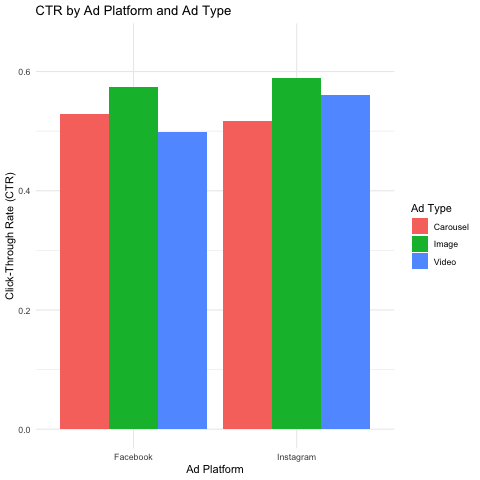

In [ ]:
%%R
# Define grouping columns
group_cols_plot <- c("ad_platform", "ad_type")

# Aggregate 
ctr_platform_type <- aggregate(
    x = list(
        total_impressions = df$impressions,
        total_clicks = df$clicks
    ),
    by = df[group_cols_plot],
    FUN = sum # Sum both columns
)

# Calculate CTR
ctr_platform_type$CTR <- ctr_platform_type$total_clicks / ctr_platform_type$total_impressions

# Sort the data frame by CTR descending before plotting
ctr_platform_type <- ctr_platform_type[order(ctr_platform_type$CTR, decreasing = TRUE), ]


# Visualize the data using ggplot2 
ggplot(ctr_platform_type, aes(x = ad_platform, y = CTR, fill = ad_type)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(
    title = "CTR by Ad Platform and Ad Type",
    y = "Click-Through Rate (CTR)",
    x = "Ad Platform",
    fill = "Ad Type"
  ) +
  theme_minimal() +
  scale_y_continuous(limits = c(0, max(ctr_platform_type$CTR, na.rm = TRUE) * 1.1))


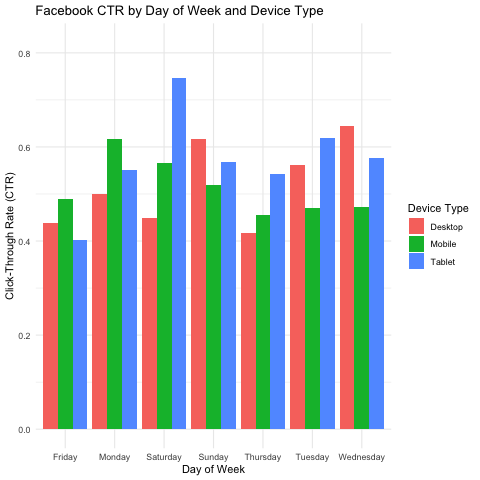

In [ ]:
%%R

# Filter for Facebook data 

fb <- df[df$ad_platform == "Facebook", ]

# Define grouping columns for the new aggregation
group_cols_fb <- c("day_of_week", "device_type")

# Aggregate
fb_ctr_day_device <- aggregate(
    x = list(
        total_impressions = fb$impressions,
        total_clicks = fb$clicks
    ),
    by = fb[group_cols_fb],
    FUN = sum
)

# Calculate CTR
fb_ctr_day_device$CTR <- fb_ctr_day_device$total_clicks / fb_ctr_day_device$total_impressions

# Sort the data frame by CTR descending
fb_ctr_day_device <- fb_ctr_day_device[order(fb_ctr_day_device$CTR, decreasing = TRUE), ]


# Visualize the data using ggplot2
ggplot(fb_ctr_day_device, aes(x = day_of_week, y = CTR, fill = device_type)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(
    title = "Facebook CTR by Day of Week and Device Type",
    y = "Click-Through Rate (CTR)",
    x = "Day of Week",
    fill = "Device Type"
  ) +
  theme_minimal() +
  scale_y_continuous(limits = c(0, max(fb_ctr_day_device$CTR, na.rm = TRUE) * 1.1))
